In [1]:
#This script analyzes counts data from the KO-seq mouse retest experiment, performed in Dectin-1-heterozygous mice

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(gridExtra)
library(extrafont)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘cowplot’ was built under R version 4.3.3”
Warning message:
“package ‘gridExtra’ was built under R version 4.3.3”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Registering fonts with R



In [3]:
font_import(pattern = 'Arial')

Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n]  y


Scanning ttf files in /usr/share/fonts/, /usr/local/share/fonts/ ...

Extracting .afm files from .ttf files...

/usr/share/fonts/truetype/msttcorefonts/Arial_Black.ttf
 : Arial-Black already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold_Italic.ttf
 : Arial-BoldItalicMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold.ttf
 : Arial-BoldMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Italic.ttf
 : Arial-ItalicMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial.ttf
 : ArialMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial.ttf
 : ArialMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold.ttf
 : Arial-BoldMT already registered in fonts database. Skipping.

/usr/share/fonts/truetype/msttcorefonts/Arial_Bold_

In [4]:
#Import files

#.csv files containing upstream and downstream KO-seq read counts
my_directory1 <- './MouseRetest_csvs/'
my_files1 <- list.files(my_directory1, pattern = '*_dedup_counts.csv')

#Dataframe of KO's in deletion library with corresponding plate numbers and QC information
KO_list <- read.csv('./KO_Plate_QC_List.csv', header = TRUE)

#Dataframe denoting which mutants are in which attenuated pool
AP_list <- read.csv('./AttenuatedPoolsGeneIDs.csv', header = TRUE)

#Dataframe containing information for C. neoformans H99 protein-coding genes, from FungiDB66
gene_info_df <- read.csv('./GeneInfo_FungiDB66.csv', header = TRUE)

#Dataframe containing processed KO-seq mouse data
mouse_data_df <- read.csv('./KOLibrary_MouseScreen_Primary.csv', header = TRUE)
mouse_data_focused <- mouse_data_df %>% select(Gene, Avg_Zadj)

In [5]:
diploid_set <- c('CNAG_01883', 'CNAG_00039', 'CNAG_01040', 'CNAG_00106', 'CNAG_00394', 'CNAG_04186', 'CNAG_04524', 'CNAG_03114',
                 'CNAG_07380', 'CNAG_02335', 'CNAG_03227', 'CNAG_03308', 'CNAG_01175', 'CNAG_02655', 'CNAG_02473', 'CNAG_03965',
                 'CNAG_03452', 'CNAG_00110', 'CNAG_00542', 'CNAG_01658', 'CNAG_03171', 'CNAG_04241', 'CNAG_05971', 'CNAG_06027')

In [6]:
#Pull out relevant columns from gene_info_df
gene_info_df <- gene_info_df %>% rename(Gene = Gene.ID, GeneName = Gene.Name.or.Symbol, ProductDescription = Product.Description) %>%
    select(Gene, GeneName, ProductDescription)

In [7]:
#Set up empty dataframe to contain upstream and downstream KO-seq counts for each mutant from mouse retest experiment
my_df1 <- data.frame(Gene = factor(),
                    Sample = factor(),
                    PoolName = factor(),
                    Condition = factor(),
                    UpCount = integer(),
                    DownCount = integer())

In [8]:
#Script below parses KO-seq .csv files, pulls relevant metadata and read counts, and writes everything to my_df1

#Iterate through .csv files
for(file_name1 in my_files1){

    #Start with files for downstream KO-seq counts
    if(grepl('_Down_', file_name1)){

        #Make general sample name
        sample_name <- paste(tail(strsplit(strsplit(file_name1, '_Down_')[[1]][[1]], '_')[[1]], -1), collapse = '_')
        
        #Find file with corresponding upstream KO-seq counts
        for(file_name2 in my_files1){
            if(grepl('_Up_', file_name2) & paste(tail(strsplit(strsplit(file_name2, '_Up_')[[1]][[1]], '_')[[1]], -1), collapse = '_') == sample_name){
                
                #Create dataframes containing downstream or upstream counts for each mutant
                down_df <- read.csv(paste(my_directory1, file_name1, sep = ''), header = TRUE) %>% select(c('Gene', 'Count')) %>% rename(DownCount = Count)
                up_df <- read.csv(paste(my_directory1, file_name2, sep = ''), header = TRUE) %>% select(c('Gene', 'Count')) %>% rename(UpCount = Count)
                
                #Merge downstream and upstream dfs, pull in KO data from KO_list, rename and reorganize columns,
                #convert NA counts to 0, merge in FungiDB gene info, add all rows to my_df
                merged_df <- merge(down_df, up_df, by = 'Gene', all = TRUE)
                merged_df <- merge(merged_df, KO_list, by = 'Gene', all.y = TRUE)
                merged_df <- mutate(merged_df,
                                    Sample = factor(sample_name)) %>%
                                    #PoolName = factor(pool_name),
                                    #Condition = factor(condition)) %>%
                select(Gene, Plate, QC, Sample, UpCount, DownCount)
                merged_df[is.na(merged_df)] <- as.double(0)
                merged_df <- merge(merged_df, gene_info_df, by = 'Gene', all.x = TRUE)
                my_df1 <- rbind(my_df1, merged_df)
            }
        }
    }
}

In [9]:
#Filter out genes that aren't in current genome annotation, that failed QC, or that are likely diploids
my_df1 <- my_df1 %>% filter(Gene %in% gene_info_df$Gene, !(QC == "Fail"), !(Gene %in% diploid_set))

In [10]:
#Merge attenuated pool list into my_df1

my_df1 <- merge(my_df1, AP_list, by.x = 'Gene', by.y = 'GeneID')

In [11]:
#Calculate normalized counts and log2 normalized counts

my_df1 <- my_df1 %>% mutate(SummedCounts = UpCount + DownCount) %>% group_by(Sample) %>%
    mutate(NormalizedCounts = ((SummedCounts/sum(SummedCounts))*1000000) + 1,
           log2NormCounts = log2(NormalizedCounts)) %>%
    ungroup()

In [12]:
#Process data for attenuated pool 1. Note analysis differs from primary screen. Originally, assumption was that most mutants in pool
#had no fitness defect in mouse. Here, attenuated pools are majority attunated mutants with 96 nonattenuated controls. To account for this,
#compare fitness relative to these 96 controls as opposed to the total population

#Create new df containing relevant samples, filter out any mutants that weren't in Attenuated Pool 1 (AP1) or the control pool (Ctrl)
AP1_df <- my_df1 %>% filter(Sample %in% c('Dectin1AP1PreInput', 'Dectin1AP1PostInput', 'Dectin1AP1Het1',
                                        'Dectin1AP1Het2', 'Dectin1AP1Het3', 'Dectin1AP1Het4', 'Dectin1AP1Het5'),
                            Pool %in% c('AP1', 'Ctrl'))
AP1_df <- AP1_df %>% select('Gene', 'Pool', 'Sample', 'log2NormCounts') %>% spread(Sample, log2NormCounts)

#Remove mutants for which we obtained <10 raw counts or <10 counts per million in control culture
AP1_PostInputRaw_df <- my_df1 %>% filter(Sample == 'Dectin1AP1PostInput') %>% select(Gene, PostInputRawSummedCounts = SummedCounts)
AP1_df <- merge(AP1_df, AP1_PostInputRaw_df, by = 'Gene', all = TRUE)
AP1_df <- AP1_df %>% filter(Dectin1AP1PostInput > log2(10), PostInputRawSummedCounts > 10)

#Calculate raw log2 fold changes in each mouse relative to control
AP1_df <- AP1_df %>% mutate(L2FC_Het1 = Dectin1AP1Het1 - Dectin1AP1PostInput,
                               L2FC_Het2 = Dectin1AP1Het2 - Dectin1AP1PostInput,
                               L2FC_Het3 = Dectin1AP1Het3 - Dectin1AP1PostInput,
                               L2FC_Het4 = Dectin1AP1Het4 - Dectin1AP1PostInput,
                               L2FC_Het5 = Dectin1AP1Het5 - Dectin1AP1PostInput)

#Calcualte mean and sd of L2FCs for control mutants in each mouse
mean_ctrl_Het1 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het1) %>% mean(.)
mean_ctrl_Het2 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het2) %>% mean(.)
mean_ctrl_Het3 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het3) %>% mean(.)
mean_ctrl_Het4 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het4) %>% mean(.)
mean_ctrl_Het5 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het5) %>% mean(.)

sd_ctrl_Het1 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het1) %>% sd(.)
sd_ctrl_Het2 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het2) %>% sd(.)
sd_ctrl_Het3 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het3) %>% sd(.)
sd_ctrl_Het4 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het4) %>% sd(.)
sd_ctrl_Het5 <- AP1_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het5) %>% sd(.)

#In each mouse, normalize L2FCs based on mean and sd of control mutants
AP1_df <- AP1_df %>% mutate(Fit_Het1 = (L2FC_Het1 - mean_ctrl_Het1)/sd_ctrl_Het1,
                            Fit_Het2 = (L2FC_Het2 - mean_ctrl_Het2)/sd_ctrl_Het2,
                            Fit_Het3 = (L2FC_Het3 - mean_ctrl_Het3)/sd_ctrl_Het3,
                            Fit_Het4 = (L2FC_Het4 - mean_ctrl_Het4)/sd_ctrl_Het4,
                            Fit_Het5 = (L2FC_Het5 - mean_ctrl_Het5)/sd_ctrl_Het5) %>%
                        rowwise() %>%
                        mutate(Avg_Fit = mean(c(Fit_Het1, Fit_Het2, Fit_Het3, Fit_Het4, Fit_Het5))) %>% ungroup()

In [13]:
#Perform same calculations as above for Attenuated Pool 2

AP2_df <- my_df1 %>% filter(Sample %in% c('Dectin1AP2PreInput', 'Dectin1AP2PostInput', 'Dectin1AP2Het1',
                                        'Dectin1AP2Het2', 'Dectin1AP2Het3', 'Dectin1AP2Het4', 'Dectin1AP2Het5'),
                            Pool %in% c('AP2', 'Ctrl'))

AP2_df <- AP2_df %>% select('Gene', 'Pool', 'Sample', 'log2NormCounts') %>% spread(Sample, log2NormCounts)

AP2_PostInputRaw_df <- my_df1 %>% filter(Sample == 'Dectin1AP2PostInput') %>% select(Gene, PostInputRawSummedCounts = SummedCounts)

AP2_df <- merge(AP2_df, AP2_PostInputRaw_df, by = 'Gene', all = TRUE)

AP2_df <- AP2_df %>% filter(Dectin1AP2PostInput > log2(10), PostInputRawSummedCounts > 10)

AP2_df <- AP2_df %>% mutate(L2FC_Het1 = Dectin1AP2Het1 - Dectin1AP2PostInput,
                               L2FC_Het2 = Dectin1AP2Het2 - Dectin1AP2PostInput,
                               L2FC_Het3 = Dectin1AP2Het3 - Dectin1AP2PostInput,
                               L2FC_Het4 = Dectin1AP2Het4 - Dectin1AP2PostInput,
                               L2FC_Het5 = Dectin1AP2Het5 - Dectin1AP2PostInput)

mean_ctrl_AP2_Het1 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het1) %>% mean(.)
mean_ctrl_AP2_Het2 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het2) %>% mean(.)
mean_ctrl_AP2_Het3 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het3) %>% mean(.)
mean_ctrl_AP2_Het4 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het4) %>% mean(.)
mean_ctrl_AP2_Het5 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het5) %>% mean(.)

sd_ctrl_AP2_Het1 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het1) %>% sd(.)
sd_ctrl_AP2_Het2 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het2) %>% sd(.)
sd_ctrl_AP2_Het3 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het3) %>% sd(.)
sd_ctrl_AP2_Het4 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het4) %>% sd(.)
sd_ctrl_AP2_Het5 <- AP2_df %>% filter(Pool == 'Ctrl') %>% pull(L2FC_Het5) %>% sd(.)

AP2_df <- AP2_df %>% mutate(Fit_Het1 = (L2FC_Het1 - mean_ctrl_AP2_Het1)/sd_ctrl_AP2_Het1,
                            Fit_Het2 = (L2FC_Het2 - mean_ctrl_AP2_Het2)/sd_ctrl_AP2_Het2,
                            Fit_Het3 = (L2FC_Het3 - mean_ctrl_AP2_Het3)/sd_ctrl_AP2_Het3,
                            Fit_Het4 = (L2FC_Het4 - mean_ctrl_AP2_Het4)/sd_ctrl_AP2_Het4,
                            Fit_Het5 = (L2FC_Het5 - mean_ctrl_AP2_Het5)/sd_ctrl_AP2_Het5) %>%
                        rowwise() %>%
                        mutate(Avg_Fit = mean(c(Fit_Het1, Fit_Het2, Fit_Het3, Fit_Het4, Fit_Het5))) %>% ungroup()

In [14]:
#Make a df that contains control mutant data from both Attenuated Pools
ctrl_df <- merge(AP1_df, AP2_df, by = 'Gene', all = TRUE)
ctrl_df <- ctrl_df %>% filter(Pool.x == 'Ctrl') %>% select(Gene, Pool.x, Avg_Fit.x, Avg_Fit.y)

#Calculate mean fitness of control mutants from the two Attenuated Pools
ctrl_df <- ctrl_df %>% mutate(Avg_Fit_combined = (Avg_Fit.x + Avg_Fit.y)/2)

In [15]:
AP1_df2 <- AP1_df %>% filter(Pool == 'AP1') %>% select(Gene, Pool, Avg_Fit)
AP2_df2 <- AP2_df %>% filter(Pool == 'AP2') %>% select(Gene, Pool, Avg_Fit)
ctrl_df2 <- ctrl_df %>% select(Gene, Pool.x, Avg_Fit_combined) %>% rename(Pool = Pool.x, Avg_Fit = Avg_Fit_combined)
combined_df <- rbind(ctrl_df2, AP1_df2, AP2_df2)

In [16]:
combined_df <- combined_df %>% mutate(Pool2 = if_else(Pool == 'Ctrl', 'Control', 'Attenuated'))

In [17]:
dectin_mouse_data_focused2 <- merge(combined_df, mouse_data_focused, by = 'Gene', all = TRUE)

In [18]:
#write.csv(dectin_mouse_data_focused2, '/output_directory/KOSeq_Mouse_Retest.csv')

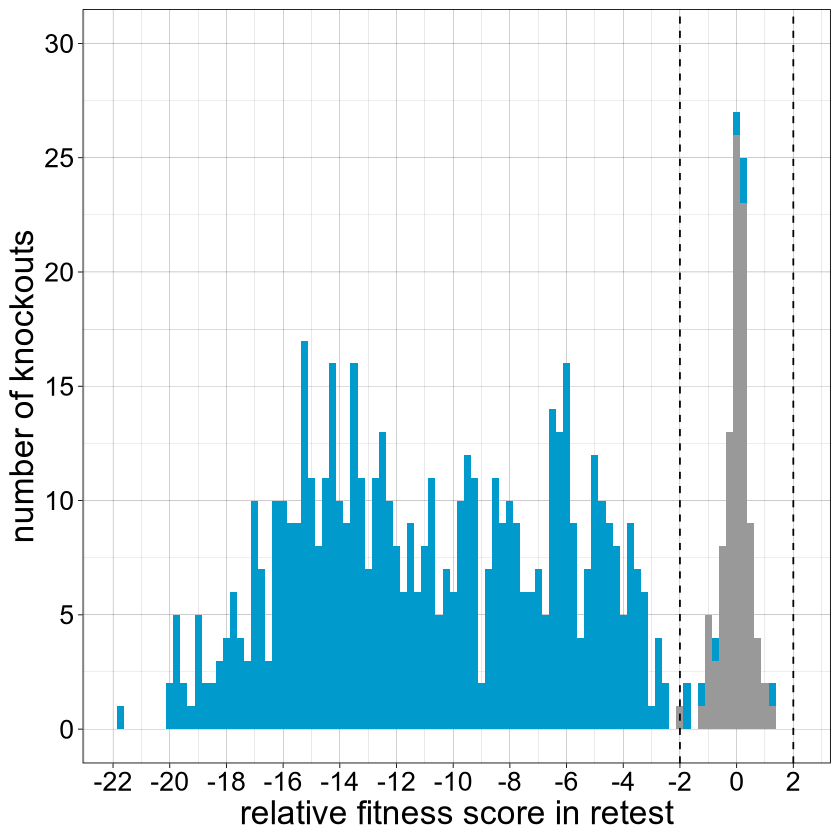

In [19]:
#Fig 4D

dectin_mouse_data_focused2 %>% filter(!is.na(Pool), !(Pool2 == 'Attenuated' & Avg_Zadj > -2)) %>%
        ggplot(aes(Avg_Fit, fill = as.factor(Pool2))) + geom_histogram(binwidth = 0.25) +
            scale_fill_manual('Classification',values = c('deepskyblue3', 'grey60'), labels = c('Attenuated', 'Neutral')) +
            theme_linedraw() +
            scale_x_continuous(breaks = seq(-22,2,2)) +
            scale_y_continuous(breaks = seq(0, 30, 5), limits = c(0, 30)) +
            geom_vline(xintercept = -2, linetype = 'dashed') +
            geom_vline(xintercept = 2, linetype = 'dashed') +
            theme(text = element_text(family = 'Arial'),
                  #panel.grid.major = element_blank(),
                  #panel.grid.minor = element_blank(),
                  axis.text = element_text(size = 16),
                  axis.title = element_text(size = 20),
                  legend.text = element_text(size = 18),
                  legend.title = element_text(size = 24),
                  legend.position = 'none',
                 ) +
            labs(x = 'relative fitness score in retest', y = 'number of knockouts')

In [20]:
#Analyze male and female mice separately to make sure no effect due to sex

Dectin1_AP1_MF_df <- AP1_df %>%
                    mutate(F_Avg_log2NormCounts = (Dectin1AP1Het1 + Dectin1AP1Het2 + Dectin1AP1Het3)/3,
                           M_Avg_log2NormCounts = (Dectin1AP1Het4 + Dectin1AP1Het5)/2,
                           F_Avg_Fit = (Fit_Het1 + Fit_Het2 + Fit_Het3)/3,
                           M_Avg_Fit = (Fit_Het4 + Fit_Het5)/2) %>%
                    rename(log2NormCounts_PreIn = Dectin1AP1PreInput,
                           log2NormCounts_PostIn = Dectin1AP1PostInput,
                           log2NormCounts_F1 = Dectin1AP1Het1,
                           log2NormCounts_F2 = Dectin1AP1Het2,
                           log2NormCounts_F3 = Dectin1AP1Het3,
                           log2NormCounts_M1 = Dectin1AP1Het4,
                           log2NormCounts_M2 = Dectin1AP1Het5
                          )

Dectin1_AP2_MF_df <- AP2_df %>%
                    mutate(F_Avg_log2NormCounts = (Dectin1AP2Het1 + Dectin1AP2Het2 + Dectin1AP2Het3)/3,
                           M_Avg_log2NormCounts = (Dectin1AP2Het4 + Dectin1AP2Het5)/2,
                           F_Avg_Fit = (Fit_Het1 + Fit_Het2 + Fit_Het3)/3,
                           M_Avg_Fit = (Fit_Het4 + Fit_Het5)/2) %>%
                    rename(log2NormCounts_PreIn = Dectin1AP2PreInput,
                           log2NormCounts_PostIn = Dectin1AP2PostInput,
                           log2NormCounts_F1 = Dectin1AP2Het1,
                           log2NormCounts_F2 = Dectin1AP2Het2,
                           log2NormCounts_F3 = Dectin1AP2Het3,
                           log2NormCounts_M1 = Dectin1AP2Het4,
                           log2NormCounts_M2 = Dectin1AP2Het5)

Dectin1_combined_MF_df <- rbind(Dectin1_AP1_MF_df, Dectin1_AP2_MF_df)

In [21]:
Dectin1_AP1_MF_df <- merge(Dectin1_AP1_MF_df, mouse_data_focused, by = 'Gene') %>% rename(PrimaryScreen_Fit = Avg_Zadj)
Dectin1_AP2_MF_df <- merge(Dectin1_AP2_MF_df, mouse_data_focused, by = 'Gene') %>% rename(PrimaryScreen_Fit = Avg_Zadj)
Dectin1_combined_MF_df <- merge(Dectin1_combined_MF_df, mouse_data_focused, by = 'Gene') %>% rename(PrimaryScreen_Fit = Avg_Zadj)

[1] 0.964308

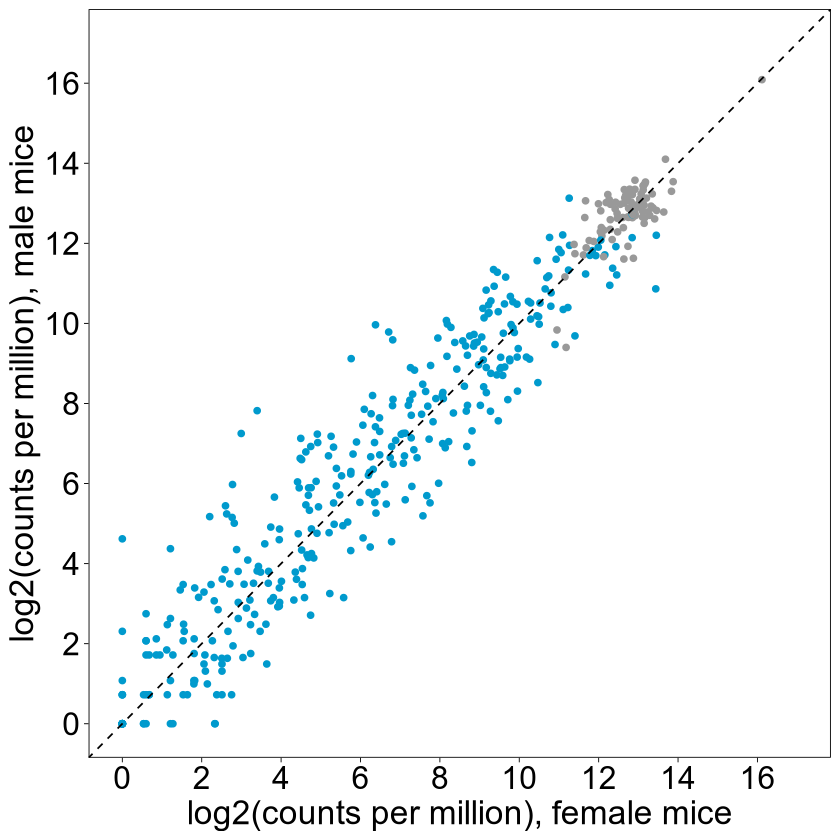

In [22]:
#Fig S6C

Dectin1_AP1_MF_df %>% ggplot(aes(F_Avg_log2NormCounts, M_Avg_log2NormCounts, color = Pool)) + geom_point() +
    theme_linedraw() +
    scale_color_manual(values = c('deepskyblue3', 'gray60')) +
    scale_x_continuous(breaks = seq(0,16,2), limits = c(0,17)) +
    scale_y_continuous(breaks = seq(0,16,2), limits = c(0,17)) +
    geom_abline(intercept = 0, slope = 1, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(),
                      panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 19),
                      axis.title = element_text(size = 20),
                      legend.text = element_text(size = 16),
                      legend.title = element_text(size = 20),
                      legend.position = 'none'
                     ) +
                labs(x = 'log2(counts per million), female mice', y = 'log2(counts per million), male mice')
    
    


cor(Dectin1_AP1_MF_df$F_Avg_log2NormCounts, Dectin1_AP1_MF_df$M_Avg_log2NormCounts)

[1] 0.9833148

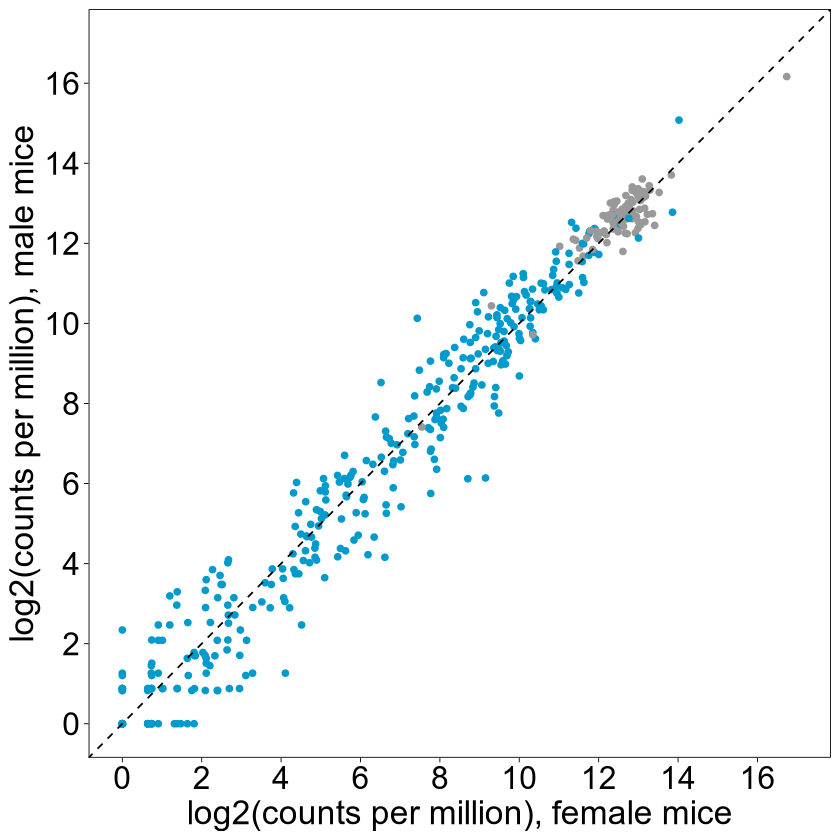

In [23]:
#Fig S6C

Dectin1_AP2_MF_df %>% ggplot(aes(F_Avg_log2NormCounts, M_Avg_log2NormCounts, color = Pool)) + geom_point() +
    theme_linedraw() +
    scale_color_manual(values = c('deepskyblue3', 'gray60')) +
    scale_x_continuous(breaks = seq(0,16,2), limits = c(0,17)) +
    scale_y_continuous(breaks = seq(0,16,2), limits = c(0,17)) +
    geom_abline(intercept = 0, slope = 1, linetype = 'dashed') +
                theme(text = element_text(family = 'Arial'),
                      panel.grid.major = element_blank(),
                      panel.grid.minor = element_blank(),
                      axis.text = element_text(size = 19),
                      axis.title = element_text(size = 20),
                      legend.text = element_text(size = 16),
                      legend.title = element_text(size = 20),
                      legend.position = 'none'
                     ) +
                labs(x = 'log2(counts per million), female mice', y = 'log2(counts per million), male mice')
    
    


cor(Dectin1_AP2_MF_df$F_Avg_log2NormCounts, Dectin1_AP2_MF_df$M_Avg_log2NormCounts)

In [24]:
#Make dataframes to calculate all pairwise correlations between replicate mice for each attenuated pool

Dectin1_AP1_MF_df_forPairwiseCors <- Dectin1_AP1_MF_df %>%
            select(log2NormCounts_F1, log2NormCounts_F2, log2NormCounts_F3, log2NormCounts_M1, log2NormCounts_M2)
Dectin1_AP1_MF_df_cors <- cor(Dectin1_AP1_MF_df_forPairwiseCors, method = 'pearson')

Dectin1_AP2_MF_df_forPairwiseCors <- Dectin1_AP2_MF_df %>%
            select(log2NormCounts_F1, log2NormCounts_F2, log2NormCounts_F3, log2NormCounts_M1, log2NormCounts_M2)
Dectin1_AP2_MF_df_cors <- cor(Dectin1_AP2_MF_df_forPairwiseCors, method = 'pearson')

Dectin1_combined_MF_df_forPairwiseCors <- Dectin1_combined_MF_df %>%
            select(log2NormCounts_F1, log2NormCounts_F2, log2NormCounts_F3, log2NormCounts_M1, log2NormCounts_M2)
Dectin1_combined_MF_df_cors <- cor(Dectin1_combined_MF_df_forPairwiseCors, method = 'pearson')

In [25]:
#Select nonredundant correlations

Dectin1_AP1_MF_df_cors_lowertri <- Dectin1_AP1_MF_df_cors
Dectin1_AP1_MF_df_cors_lowertri[!lower.tri(Dectin1_AP1_MF_df_cors_lowertri)] <- NA

Dectin1_AP2_MF_df_cors_lowertri <- Dectin1_AP2_MF_df_cors
Dectin1_AP2_MF_df_cors_lowertri[!lower.tri(Dectin1_AP2_MF_df_cors_lowertri)] <- NA

In [26]:
#Make correlation tables

Dectin1_AP1_MF_df_cors_tidy <- Dectin1_AP1_MF_df_cors_lowertri %>% as_tibble(rownames = "MouseA") %>%
pivot_longer(
    cols = -MouseA,
    names_to = "MouseB",
    values_to = "Correlation") %>% filter(!(is.na(Correlation))) %>%
mutate(Comparison = c('FF', 'FF', 'FF', 'MF', 'MF', 'MF', 'MF', 'MF', 'MF', 'MM'),
      Pool = c('AP1', 'AP1', 'AP1', 'AP1', 'AP1', 'AP1', 'AP1', 'AP1', 'AP1', 'AP1'))

Dectin1_AP2_MF_df_cors_tidy <- Dectin1_AP2_MF_df_cors_lowertri %>% as_tibble(rownames = "MouseA") %>%
pivot_longer(
    cols = -MouseA,
    names_to = "MouseB",
    values_to = "Correlation") %>% filter(!(is.na(Correlation))) %>%
mutate(Comparison = c('FF', 'FF', 'FF', 'MF', 'MF', 'MF', 'MF', 'MF', 'MF', 'MM'),
      Pool = c('AP2', 'AP2', 'AP2', 'AP2', 'AP2', 'AP2', 'AP2', 'AP2', 'AP2', 'AP2'))

In [27]:
#Combine into single df

Dectin1_AP1_AP2_MF_df_cors_tidy <- rbind(Dectin1_AP1_MF_df_cors_tidy, Dectin1_AP2_MF_df_cors_tidy)

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


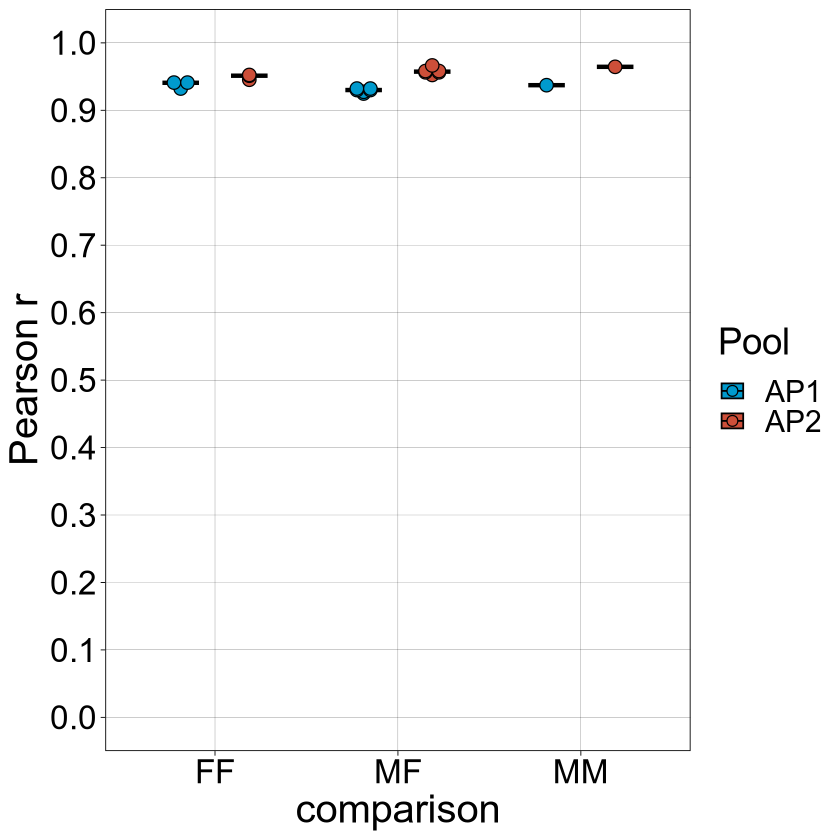

In [28]:
#Fig S6D

Dectin1_AP1_AP2_MF_df_cors_tidy %>% ggplot(aes(as.factor(Comparison), Correlation, fill = Pool)) +
            stat_summary(fun.y = median, geom = 'crossbar', width = 0.4, size = 0.5, position = position_dodge(width = 0.75)) +
            geom_dotplot(binaxis = 'y', stackdir = 'center', dotsize = 20, binpositions = 'all',
                         binwidth = 0.001, position = position_dodge(width = 0.75)) +
            scale_y_continuous(breaks = seq(0, 1, 0.1), limits = c(0,1)) +
    scale_fill_manual(values = c('deepskyblue3', 'tomato3')) +
            theme_linedraw() +
            theme(text = element_text(family = 'Arial'),
                  panel.grid.minor = element_blank(),
                  axis.text = element_text(size = 20),
                  axis.title = element_text(size = 24),
                 legend.text = element_text(size = 18),
                 legend.title = element_text(size = 22),
                 ) +
            labs(x = 'comparison', y = 'Pearson r')